In [10]:
# general utilities
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np

import timeit
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

def show_img(img, dpi=32):
    plt.figure(dpi=dpi)
    plt.axis('off')
    plt.imshow(img)

Let's create simple environment with the help of `make`, jit-compile the `reset` and `step`, step the environment and visualize the resuling state:

Observation shape: (5, 5, 2)
Num actions: 6
TimeStep shapes: TimeStep(state=State(key=(), step_num=(), grid=(16, 16, 2), agent=AgentState(position=(2,), direction=(), pocket=(2,)), goal_encoding=(5,), rule_encoding=(1, 7), carry=EnvCarry()), step_type=(), reward=(), discount=(), observation=(5, 5, 2))
TimeStep shapes: TimeStep(state=State(key=(), step_num=(), grid=(16, 16, 2), agent=AgentState(position=(2,), direction=(), pocket=(2,)), goal_encoding=(5,), rule_encoding=(1, 7), carry=EnvCarry()), step_type=(), reward=(), discount=(), observation=(5, 5, 2))


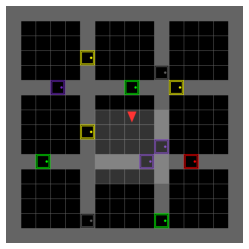

In [9]:
import xminigrid

key = jax.random.key(1)
key, reset_key = jax.random.split(key)

# to list available environments: xminigrid.registered_environments()
env, env_params = xminigrid.make("XLand-MiniGrid-R9-16x16")
print("Observation shape:", env.observation_shape(env_params))
print("Num actions:", env.num_actions(env_params))

# fully jit-compatible step and reset methods
timestep = jax.jit(env.reset)(env_params, reset_key)
timestep = jax.jit(env.step)(env_params, timestep, action=0)

print("TimeStep shapes:", jtu.tree_map(jnp.shape, timestep))

show_img(env.render(env_params, timestep), dpi=64)

In [139]:
from xminigrid.wrappers import GymAutoResetWrapper

# alternatively users can provide step_fn and reset_fn instead
# of the closure, but in whis way it is simpler to use after the creation
def build_rollout(env, env_params, num_steps):
    def rollout(rng):
        def _step_fn(carry, _):
            rng, timestep = carry
            rng, _rng = jax.random.split(rng)
            action = jax.random.randint(_rng, shape=(), minval=0, maxval=env.num_actions(env_params))
            
            timestep = env.step(env_params, timestep, action)
            return (rng, timestep), timestep
    
        rng, _rng = jax.random.split(rng)
    
        timestep = env.reset(env_params, _rng)
        rng, transitions = jax.lax.scan(_step_fn, (rng, timestep), None, length=num_steps)
        return transitions

    return rollout


env, env_params = xminigrid.make("XLand-MiniGrid-R9-16x16")
# do not forget to use auto reset wrapper!
env = GymAutoResetWrapper(env)

rng = jax.random.key(0)
ruleset_rng = jax.random.split(rng, num=1)
benchmark = xminigrid.load_benchmark("medium-1m")
rulesets = benchmark.sample_ruleset(rng)
meta_env_params = env_params.replace(ruleset=rulesets)
print(env_params.ruleset)
print('-' * 10)
print(meta_env_params.ruleset)

# jiting the entire rollout
rollout_fn = jax.jit(build_rollout(env, meta_env_params, num_steps=1000))

# first execution will compile
transitions = rollout_fn(jax.random.key(0))

print("Transitions shapes: \n", jtu.tree_map(jnp.shape, transitions))

RuleSet(goal=Array([0, 0, 0, 0, 0], dtype=uint8), rules=Array([[0, 0, 0, 0, 0, 0, 0]], dtype=uint8), init_tiles=Array([[0, 0]], dtype=uint8))
----------
RuleSet(goal=Array([12,  5,  5,  0,  0], dtype=int32), rules=Array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=uint8), init_tiles=Array([[ 5,  5],
       [ 5,  6],
       [12,  1],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0]], dtype=uint8))
Transitions shapes: 
 TimeStep(state=State(key=(1000,), step_num=(1000,), grid=(1000, 16, 16, 2), agent=AgentState(position=(1000, 2), direction=(1000,), pocket=(1000, 2)), goal_encoding=(1000, 5), rule_

### Visualization

Rollouts can be visualized as usuall, just record all timesteps, then render them with `env.render`:

In [140]:
images = []

for i in trange(1000):
    timestep = jtu.tree_map(lambda x: x[i], transitions)
    images.append(env.render(env_params, timestep))

imageio.mimsave("example_rollout.mp4", images, fps=32, format="mp4")

100%|██████████| 1000/1000 [00:02<00:00, 486.38it/s]
/opt/miniconda3/envs/metarl/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(

/opt/miniconda3/envs/metarl/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [142]:
from IPython.display import Video

Video("example_rollout.mp4", embed=True)

In [114]:
import orbax

from training.nn import ActorCriticRNNNull


network = ActorCriticRNNNull(
    num_actions=env.num_actions(env_params),
    obs_emb_dim=32,
    action_emb_dim=32,
    rnn_hidden_dim=1024,
    rnn_num_layers=1,
    head_hidden_dim=256,
)

orbax_checkpointer = orbax.checkpoint.StandardCheckpointer()
params = orbax_checkpointer.restore("/Users/light/research/meta-rl/repositories/xland-minigrid/checkpoints/h0_42")

In [115]:
shapes = env.observation_shape(env_params)
init_obs = {
    "obs_img": jnp.zeros((1, 1, 5, 5, 2)),
    "obs_dir": jnp.zeros((1, 1, 4)),
    "prev_action": jnp.zeros((1, 1, 4), dtype=jnp.int32),
    "prev_reward": jnp.zeros((1, 1, 1), dtype=jnp.float32),
}
init_hstate = network.initialize_carry(batch_size=1)


In [116]:
init_hstate.shape

(1, 1, 1024)

In [117]:
rng = jax.random.key(0)
network_params = network.init(rng, init_obs, init_hstate)

In [81]:
timestep.state.agent

AgentState(position=Array([1, 2], dtype=int32), direction=Array(3, dtype=int32), pocket=Array([0, 0], dtype=uint8))

In [122]:
dist, _, hstate = network.apply(
    params,
    {
        "obs_img": timestep.observation[None, None, ...],
        "obs_dir": jnp.zeros((1, 1, 4)),
        "prev_action": jnp.zeros((1, 1, 1), dtype=jnp.int32),
        "prev_reward": jnp.zeros((1, 1, 1), dtype=jnp.float32),
    },
    init_hstate,
)

In [124]:
action = dist.sample(seed=rng).squeeze()

In [147]:
def build_model_rollout(env, env_params, network, network_params, num_steps):
    """
    Build a rollout function that uses the trained model to select actions
    """
    def rollout(rng):
        def _step_fn(carry, _):
            rng, timestep, hstate = carry
            rng, policy_rng = jax.random.split(rng)
            
            # Prepare observation for the network
            obs = {
                "obs_img": timestep.observation[None, None, ...],  # Add batch and sequence dims
                "obs_dir": jnp.zeros((1, 1, 4)),  # Agent direction (if needed)
                "prev_action": jnp.zeros((1, 1, 1), dtype=jnp.int32),  # Previous action
                "prev_reward": timestep.reward[None, None, None].astype(jnp.float32),  # Previous reward
            }
            
            # Get action distribution from the network
            action_dist, value, new_hstate = network.apply(network_params, obs, hstate)
            
            # Sample action from the distribution
            action = action_dist.sample(seed=policy_rng).squeeze()
            
            # Step the environment
            new_timestep = env.step(env_params, timestep, action)
            
            return (rng, new_timestep, new_hstate), new_timestep
    
        # Initialize
        rng, reset_rng = jax.random.split(rng)
        timestep = env.reset(env_params, reset_rng)
        
        # Initialize hidden state for the RNN
        init_hstate = network.initialize_carry(batch_size=1)
        
        # Run the rollout
        (rng, final_timestep, final_hstate), transitions = jax.lax.scan(
            _step_fn, (rng, timestep, init_hstate), None, length=num_steps
        )
        
        return transitions

    return rollout

# Create and JIT compile the model rollout function
model_rollout_fn = jax.jit(build_model_rollout(env, meta_env_params, network, params, num_steps=10000))

print("Model rollout function created and JIT compiled!")

Model rollout function created and JIT compiled!


In [148]:
# Run a rollout with the trained model
print("Running model rollout...")
start_time = timeit.default_timer()

# Generate rollout using the trained model
model_transitions = model_rollout_fn(jax.random.key(42))  # Using a different seed

end_time = timeit.default_timer()
print(f"Model rollout completed in {end_time - start_time:.4f} seconds")
print("Model transitions shapes: \n", jtu.tree_map(jnp.shape, model_transitions))

Running model rollout...
Model rollout completed in 1.7096 seconds
Model transitions shapes: 
 TimeStep(state=State(key=(10000,), step_num=(10000,), grid=(10000, 16, 16, 2), agent=AgentState(position=(10000, 2), direction=(10000,), pocket=(10000, 2)), goal_encoding=(10000, 5), rule_encoding=(10000, 9, 7), carry=EnvCarry()), step_type=(10000,), reward=(10000,), discount=(10000,), observation=(10000, 5, 5, 2))
Model rollout completed in 1.7096 seconds
Model transitions shapes: 
 TimeStep(state=State(key=(10000,), step_num=(10000,), grid=(10000, 16, 16, 2), agent=AgentState(position=(10000, 2), direction=(10000,), pocket=(10000, 2)), goal_encoding=(10000, 5), rule_encoding=(10000, 9, 7), carry=EnvCarry()), step_type=(10000,), reward=(10000,), discount=(10000,), observation=(10000, 5, 5, 2))


In [ ]:
# Create visualization of the model's behavior
print("Rendering model rollout frames...")
model_images = []

for i in trange(10000, desc="Rendering frames"):
    model_timestep = jtu.tree_map(lambda x: x[i], model_transitions)
    model_images.append(env.render(meta_env_params, model_timestep))

# Save the model rollout as a video
model_video_path = "model_rollout.mp4"
imageio.mimsave(model_video_path, model_images, fps=32, format="mp4")
print(f"Model rollout saved as {model_video_path}")

# Display some key statistics
total_reward = jnp.sum(model_transitions.reward)
episode_lengths = []
current_length = 0

for i in range(10000):
    current_length += 1
    if model_transitions.step_type[i] == 2:  # LAST step (episode ended)
        episode_lengths.append(current_length)
        current_length = 0

print(f"\nModel Performance Summary:")
print(f"Total reward collected: {total_reward:.2f}")
print(f"Number of episodes completed: {len(episode_lengths)}")
if episode_lengths:
    print(f"Average episode length: {np.mean(episode_lengths):.2f}")
    print(f"Shortest episode: {min(episode_lengths)}")
    print(f"Longest episode: {max(episode_lengths)}")
else:
    print("No episodes completed in the rollout")

Rendering model rollout frames...


Rendering frames: 100%|██████████| 10000/10000 [00:16<00:00, 607.06it/s]



In [146]:
# Display the model rollout video
from IPython.display import Video

print("Model Rollout Video:")
Video("model_rollout.mp4", embed=True, width=600)

Model Rollout Video:


## Comparison: Random vs Model Behavior

Let's compare the random rollout with the model rollout to see the difference in behavior:

In [130]:
# Compare random vs model behavior
def analyze_rollout(transitions, name):
    """Analyze a rollout and return statistics"""
    total_reward = jnp.sum(transitions.reward)
    episode_lengths = []
    current_length = 0
    
    for i in range(len(transitions.reward)):
        current_length += 1
        if transitions.step_type[i] == 2:  # LAST step (episode ended)
            episode_lengths.append(current_length)
            current_length = 0
    
    stats = {
        'name': name,
        'total_reward': float(total_reward),
        'num_episodes': len(episode_lengths),
        'avg_episode_length': np.mean(episode_lengths) if episode_lengths else current_length,
        'min_episode_length': min(episode_lengths) if episode_lengths else current_length,
        'max_episode_length': max(episode_lengths) if episode_lengths else current_length
    }
    
    return stats

# Analyze both rollouts
random_stats = analyze_rollout(transitions, "Random Policy")
model_stats = analyze_rollout(model_transitions, "Trained Model")

# Print comparison
print("🎯 BEHAVIOR COMPARISON")
print("=" * 50)
print(f"{'Metric':<25} {'Random':<15} {'Model':<15}")
print("-" * 50)
print(f"{'Total Reward':<25} {random_stats['total_reward']:<15.2f} {model_stats['total_reward']:<15.2f}")
print(f"{'Episodes Completed':<25} {random_stats['num_episodes']:<15d} {model_stats['num_episodes']:<15d}")
print(f"{'Avg Episode Length':<25} {random_stats['avg_episode_length']:<15.2f} {model_stats['avg_episode_length']:<15.2f}")
print(f"{'Min Episode Length':<25} {random_stats['min_episode_length']:<15d} {model_stats['min_episode_length']:<15d}")
print(f"{'Max Episode Length':<25} {random_stats['max_episode_length']:<15d} {model_stats['max_episode_length']:<15d}")

print(f"\n📊 PERFORMANCE SUMMARY:")
print(f"The trained model completed {model_stats['num_episodes']} episode(s) with total reward {model_stats['total_reward']:.2f}")
print(f"Random policy completed {random_stats['num_episodes']} episode(s) with total reward {random_stats['total_reward']:.2f}")

if model_stats['total_reward'] > random_stats['total_reward']:
    print("✅ Model outperforms random policy!")
elif model_stats['total_reward'] == random_stats['total_reward']:
    print("➖ Model performs similarly to random policy")
else:
    print("❌ Model underperforms compared to random policy")

🎯 BEHAVIOR COMPARISON
Metric                    Random          Model          
--------------------------------------------------
Total Reward              0.00            0.00           
Episodes Completed        1               1              
Avg Episode Length        768.00          768.00         
Min Episode Length        768             768            
Max Episode Length        768             768            

📊 PERFORMANCE SUMMARY:
The trained model completed 1 episode(s) with total reward 0.00
Random policy completed 1 episode(s) with total reward 0.00
➖ Model performs similarly to random policy


🖼️ SAMPLE FRAMES COMPARISON


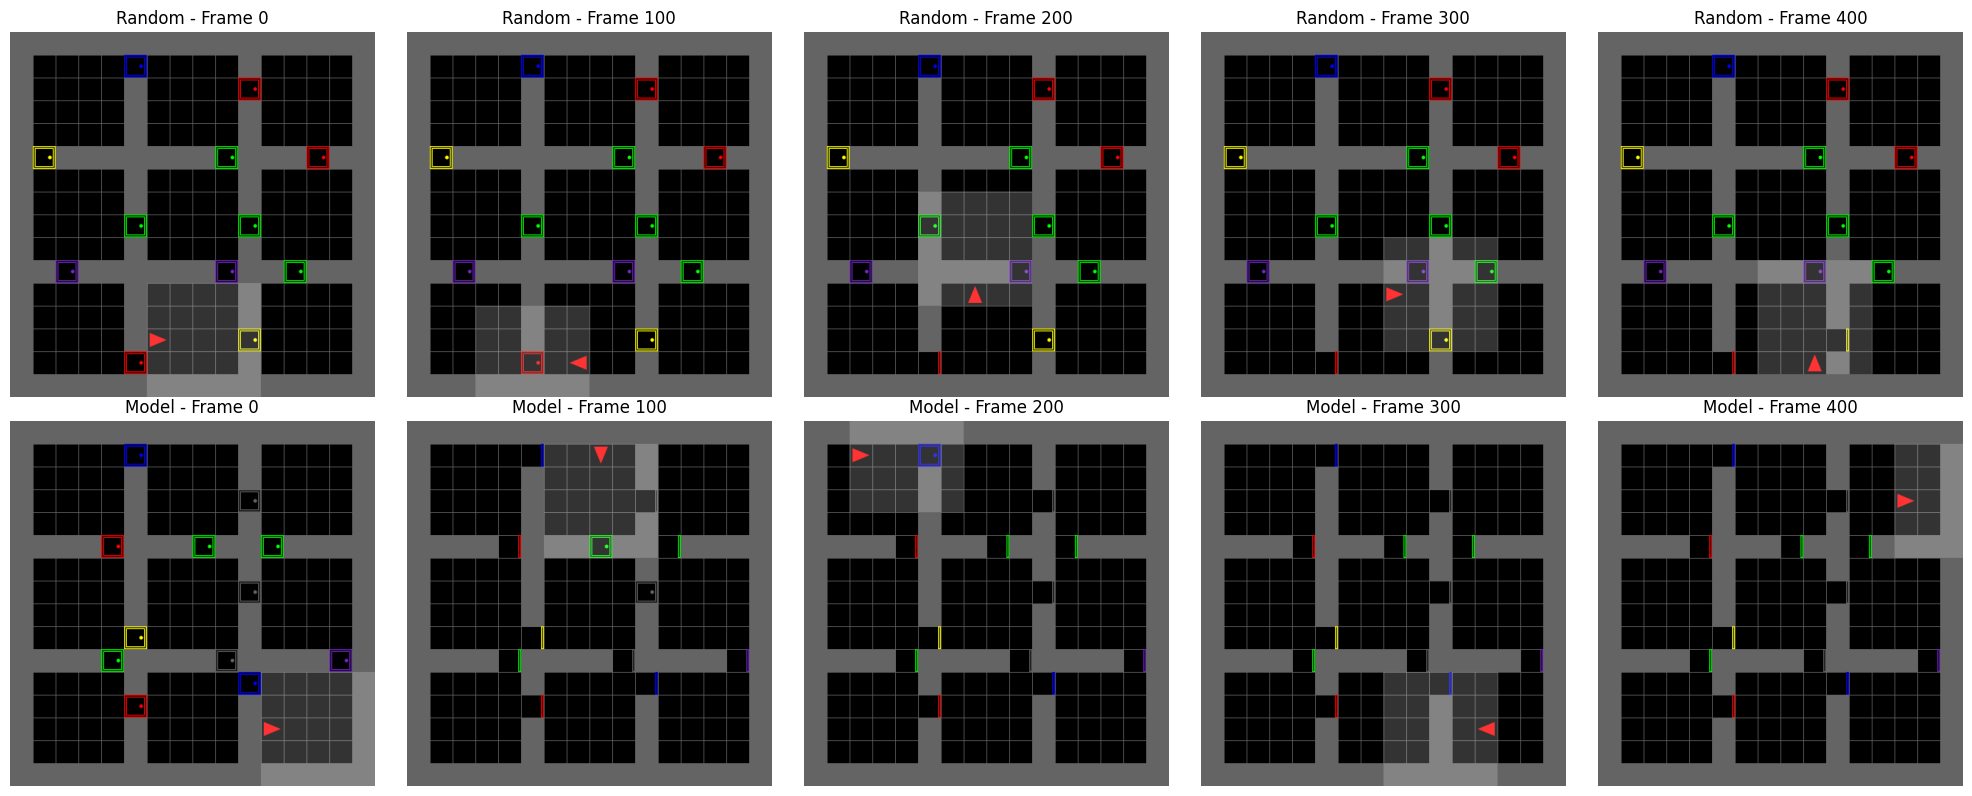

In [131]:
# Display sample frames to see behavior differences
def display_sample_frames(random_images, model_images, frame_indices=[0, 100, 200, 300, 400]):
    """Display sample frames from both rollouts side by side"""
    fig, axes = plt.subplots(2, len(frame_indices), figsize=(20, 8))
    
    for i, frame_idx in enumerate(frame_indices):
        if frame_idx < len(random_images):
            axes[0, i].imshow(random_images[frame_idx])
            axes[0, i].set_title(f'Random - Frame {frame_idx}')
            axes[0, i].axis('off')
        
        if frame_idx < len(model_images):
            axes[1, i].imshow(model_images[frame_idx])
            axes[1, i].set_title(f'Model - Frame {frame_idx}')
            axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Random Policy', fontsize=14, rotation=90, labelpad=20)
    axes[1, 0].set_ylabel('Trained Model', fontsize=14, rotation=90, labelpad=20)
    
    plt.tight_layout()
    plt.show()

# Display sample frames
print("🖼️ SAMPLE FRAMES COMPARISON")
display_sample_frames(images, model_images)